In [1]:
import lib.db_connector
import pandas as pd
import seaborn as sns

#Set to true if database connection is not available
local = True

if not local:
    db = lib.db_connector.DbConnector(db_name = 'speakql_study', verbose = False)
    query = open("./queries/get_all_final_attempts_with_feature_usage.sql").read()
    final_attempts = db.do_single_select_query_into_dataframe(query)
    final_attempts.to_excel('./data/df/group-effect-analysis-final-attempts.xlsx')
else:
    final_attempts = pd.read_excel('./data/df/group-effect-analysis-final-attempts.xlsx')

final_attempts = final_attempts.where(final_attempts.tot_pt < 500).dropna(how = 'all')
final_attempts = final_attempts.where(final_attempts.ispractice == 0).dropna(how = 'all')

final_attempts['tot_pt'] = final_attempts['tot_pt'].astype('float')

final_attempts['relative_step'] = final_attempts.apply(
    lambda row: row.idstep - 6 if row.idstep < 19 else row.step - 18, axis = 1
)

final_attempts['second_half'] = final_attempts.apply(
    lambda row: 0 if row.idstep <= 18 else 1,
    axis = 1
)

print(final_attempts.columns)
final_attempts

Index(['Unnamed: 0', 'idparticipant', 'idsession', 'idattemptsubmission',
       'idquery', 'idstep', 'attemptnum', 'total_time', 'recording_time',
       'planning_time', 'tot_pt', 'first_pt', 'tot_tt', 'groupnum', 'step',
       'speakql_first', 'language', 'ispractice', 'correct', 'usedspeakql',
       'complexity', 'normalized', 'is_complex', 'num_mods', 'num_joins',
       'num_funcs', 'num_proj', 'num_tables', 'num_selections',
       'used_unbundling', 'unbundling_possible', 'used_natural_functions',
       'natural_functions_possible', 'used_mod_ordering',
       'mod_ordering_possible', 'used_expression_ordering',
       'expression_ordering_possible', 'used_synonyms', 'synonyms_possible',
       'relative_step', 'second_half'],
      dtype='object')


,Unnamed: 0,idparticipant,idsession,idattemptsubmission,idquery,idstep,attemptnum,total_time,recording_time,planning_time,...,used_natural_functions,natural_functions_possible,used_mod_ordering,mod_ordering_possible,used_expression_ordering,expression_ordering_possible,used_synonyms,synonyms_possible,relative_step,second_half
135,135.0,2.0,41.0,285.0,2.0,7.0,1.0,41.0,7.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
136,136.0,4.0,45.0,397.0,2.0,7.0,1.0,29.0,9.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
137,137.0,8.0,49.0,555.0,2.0,7.0,1.0,17.0,6.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
138,138.0,6.0,47.0,634.0,2.0,7.0,1.0,49.0,9.0,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
139,139.0,10.0,51.0,677.0,2.0,7.0,1.0,65.0,6.0,58.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,658.0,2.0,41.0,322.0,17.0,30.0,2.0,55.0,52.0,3.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,12.0,1
659,659.0,4.0,45.0,433.0,17.0,30.0,2.0,101.0,90.0,11.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,12.0,1
660,660.0,6.0,47.0,668.0,17.0,30.0,2.0,118.0,109.0,9.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,12.0,1
661,661.0,6.0,47.0,668.0,17.0,30.0,2.0,118.0,109.0,9.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,12.0,1


### Comparison of means between groups
Group 1: SpeakQL then SQL

Group 2: SQL then SpeakQL

Method based on Scott Mackenzi Human Computer Interaction Chapter 5, page 183: Group effects and asymmetric skill transfer.

In [2]:
from scipy.stats import mannwhitneyu as mwu
from scipy.ndimage import median

p_val = mwu(
    x = final_attempts.where(final_attempts.groupnum=='group1').dropna(how='all')['first_pt'],
    y = final_attempts.where(final_attempts.groupnum=='group2').dropna(how='all')['first_pt']
)[1]

#Group 1 SpeakQL -> SQL
#Group 2 SQL -> SpeakQL

median_grp1 = median(final_attempts.where(final_attempts.groupnum=='group1').dropna(how='all')['first_pt'])
median_grp2 = median(final_attempts.where(final_attempts.groupnum=='group2').dropna(how='all')['first_pt'])

print(p_val, median_grp1, median_grp2)

7.735220836227046e-05 62.0 44.5


56.958955223880594 41.25581395348837


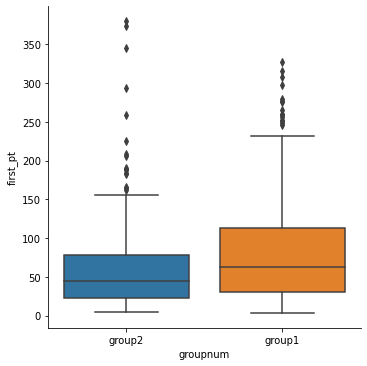

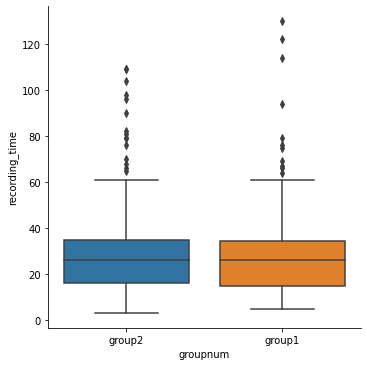

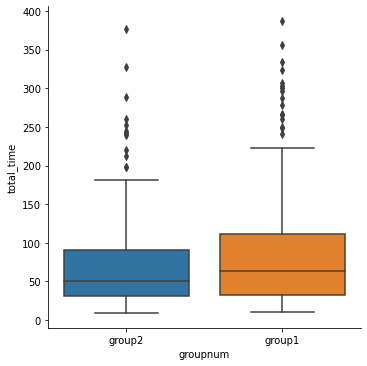

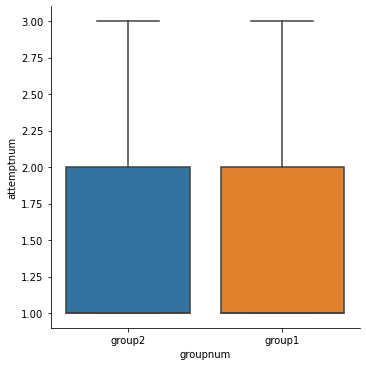

In [3]:
g = sns.catplot(x='groupnum', y='first_pt', data=final_attempts, kind='box')

g2 = sns.catplot(x='groupnum', y='recording_time', data=final_attempts, kind='box')

g3 = sns.catplot(x='groupnum', y='total_time', data=final_attempts, kind='box')

g4 = sns.catplot(x='groupnum', y='attemptnum', data=final_attempts, kind='box')

print(
    final_attempts.where(
        final_attempts.groupnum=='group1'
    ).dropna(how='all').planning_time.mean(),
    final_attempts.where(
        final_attempts.groupnum=='group2'
    ).dropna(how='all').planning_time.mean()
)

In [4]:
final_attempts.columns

Index(['Unnamed: 0', 'idparticipant', 'idsession', 'idattemptsubmission',
       'idquery', 'idstep', 'attemptnum', 'total_time', 'recording_time',
       'planning_time', 'tot_pt', 'first_pt', 'tot_tt', 'groupnum', 'step',
       'speakql_first', 'language', 'ispractice', 'correct', 'usedspeakql',
       'complexity', 'normalized', 'is_complex', 'num_mods', 'num_joins',
       'num_funcs', 'num_proj', 'num_tables', 'num_selections',
       'used_unbundling', 'unbundling_possible', 'used_natural_functions',
       'natural_functions_possible', 'used_mod_ordering',
       'mod_ordering_possible', 'used_expression_ordering',
       'expression_ordering_possible', 'used_synonyms', 'synonyms_possible',
       'relative_step', 'second_half'],
      dtype='object')

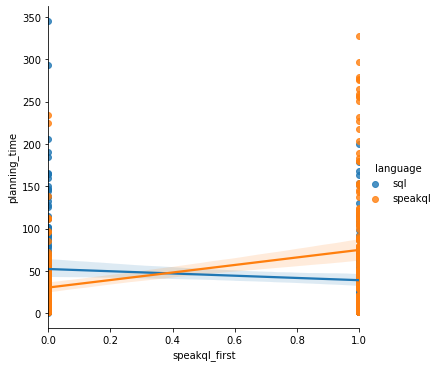

In [5]:
sns.lmplot(data = final_attempts, 
           x = 'speakql_first', 
           y = 'planning_time',
           hue = 'language'
          )

Here we are checking for learning effect based on page 183 of Mackenzie's Human-Computer Interaction An Empirical Research Perspective text.

We break the data into two sections: queries performed in the first half, and queries performed in the second half. We should observe a learning effect (performance improves in the second half) that is consistent between languages. This is indicated by somewhat parallel lines. 

There is an asymmetric learning effect if the lines intersect dramatically, indicating that learning occurs in the first half of the experiment that affects the second half disproportionately.

In [6]:
final_attempts['tot_tt'] = final_attempts.tot_tt.astype(int)

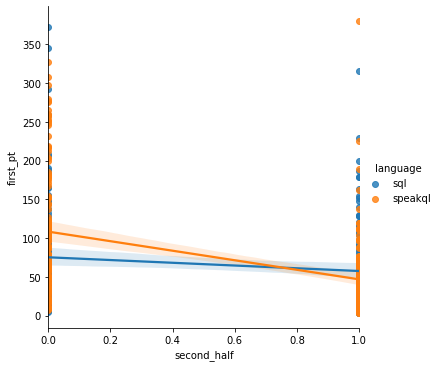

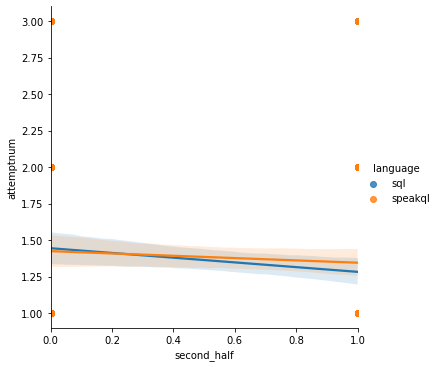

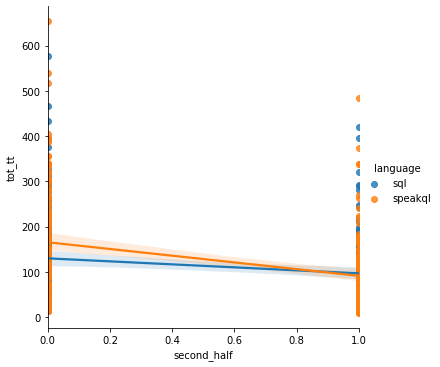

In [7]:
sns.lmplot(data = final_attempts,
           x = 'second_half',
           y = 'first_pt',
           hue = 'language'
          )

sns.lmplot(data = final_attempts,
           x = 'second_half',
           y = 'attemptnum',
           hue = 'language'
          )

sns.lmplot(data = final_attempts,
           x = 'second_half',
           y = 'tot_tt',
           hue = 'language'
          )